In [1]:
USE_YAM = True
if not USE_YAM:
    DID = ''
else:
    DID = 'y'

In [2]:
import random
import math
import os
import csv

from scipy import stats

import numpy as np
import pandas as pd

from Bio import SeqUtils
from Bio.Seq import Seq
from Bio import motifs
from Bio.motifs import parse

import pickle

from tqdm.notebook import tqdm

from scipy.stats import spearmanr, pearsonr
from statsmodels.stats.multitest import fdrcorrection

from sklearn.impute import SimpleImputer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import confusion_matrix
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import r2_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error as mse
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.tree import plot_tree

from umap.umap_ import UMAP

import matplotlib.pyplot as plt
import seaborn as sns
import umap.plot  # pip install umap-learn[plot]
import plotly
from plotly import version
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)
import plotly.express as px
random.seed(2021)

In [3]:
%matplotlib inline

In [4]:
if not USE_YAM:
    utr_seq = pd.read_csv('../processed_data/utrs.csv', header = 0)
    utr_seq = utr_seq.loc[:,['Gene Name', 'foreign']]
    utr_seq.rename(columns = {'Gene Name':'gene', 'foreign':'utr_seq'}, inplace = True)
    utr_seq = utr_seq.loc[utr_seq.utr_seq.notna()]
    utr_seq = utr_seq.loc[utr_seq.gene.notna()]
    utr_seq
    genes_fi = pd.read_csv('../processed_data/fluorescence_dataset.csv')
    genes_fi.dropna(subset=['intensity'],inplace=True)
    genes_fi = genes_fi.loc[genes_fi.intensity.notna()]
    genes_fi = genes_fi.loc[genes_fi.intensity > 0]
    # genes_fi.intensity, _ = stats.boxcox(genes_fi.intensity)
    fi_trans = [math.log(fi) for fi in genes_fi.intensity]
    genes_fi.intensity = fi_trans
    genes_fi = genes_fi.loc[genes_fi.intensity > -20]
    genes_fi
    df = pd.merge(genes_fi, utr_seq, on = 'gene')
    df = df.loc[df.intensity.notna()]
    df.drop_duplicates(inplace = True)
else:
    utr_seq = pd.read_csv('../processed_data/yamanishi_data.csv', header = 0)
    utr_seq = utr_seq.loc[utr_seq.utr_seq.notna()]
    utr_seq = utr_seq.loc[utr_seq.gene.notna()]
    utr_seq
    df = utr_seq
    df = df.loc[df.intensity.notna()]
    df.drop_duplicates(inplace = True)

In [5]:
df['utr_seq'].apply(lambda x: len(x)).min()

400

<AxesSubplot:>

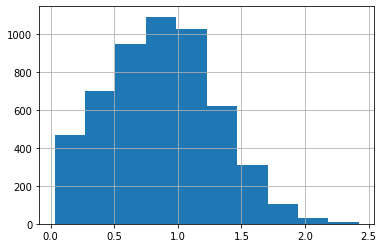

In [6]:
df.intensity.hist()

In [7]:
df = df.loc[df.intensity.notna()]
df.drop_duplicates(inplace = True)

In [8]:
df['int_group'] = np.digitize(df['intensity'].values, df['intensity'].quantile(np.arange(0,1,0.1)).values) - 1

In [9]:
df.groupby('int_group').gene.count()

int_group
0    531
1    530
2    530
3    530
4    530
5    530
6    530
7    530
8    530
9    531
Name: gene, dtype: int64

### Sequence features extraction

In [10]:
# Length of the sequence
df['len_seq'] = [len(i) for i in df.loc[:,'utr_seq']]
df['len_seq_log'] = [math.log2(len(i)) for i in df.loc[:,'utr_seq']]

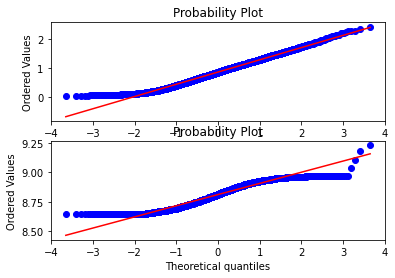

In [11]:
fig = plt.figure()
ax1 = fig.add_subplot(211)
prob = stats.probplot(df.intensity, dist=stats.norm, plot=ax1)

ax2 = fig.add_subplot(212)
prob = stats.probplot(df.len_seq_log, dist=stats.norm, plot=ax2)


In [12]:
# AT/GC ratio
df['at_gc'] = [(i.count('A')+i.count('T'))/(i.count('G')+i.count('C')) for i in df.loc[:,'utr_seq']]

In [13]:
# Percent GC
df['pct_gc'] = [SeqUtils.GC(i) for i in df.loc[:,'utr_seq']]

In [14]:
# Molecular weight
df['molecular_w'] = [SeqUtils.molecular_weight(i) for i in df.loc[:,'utr_seq']]

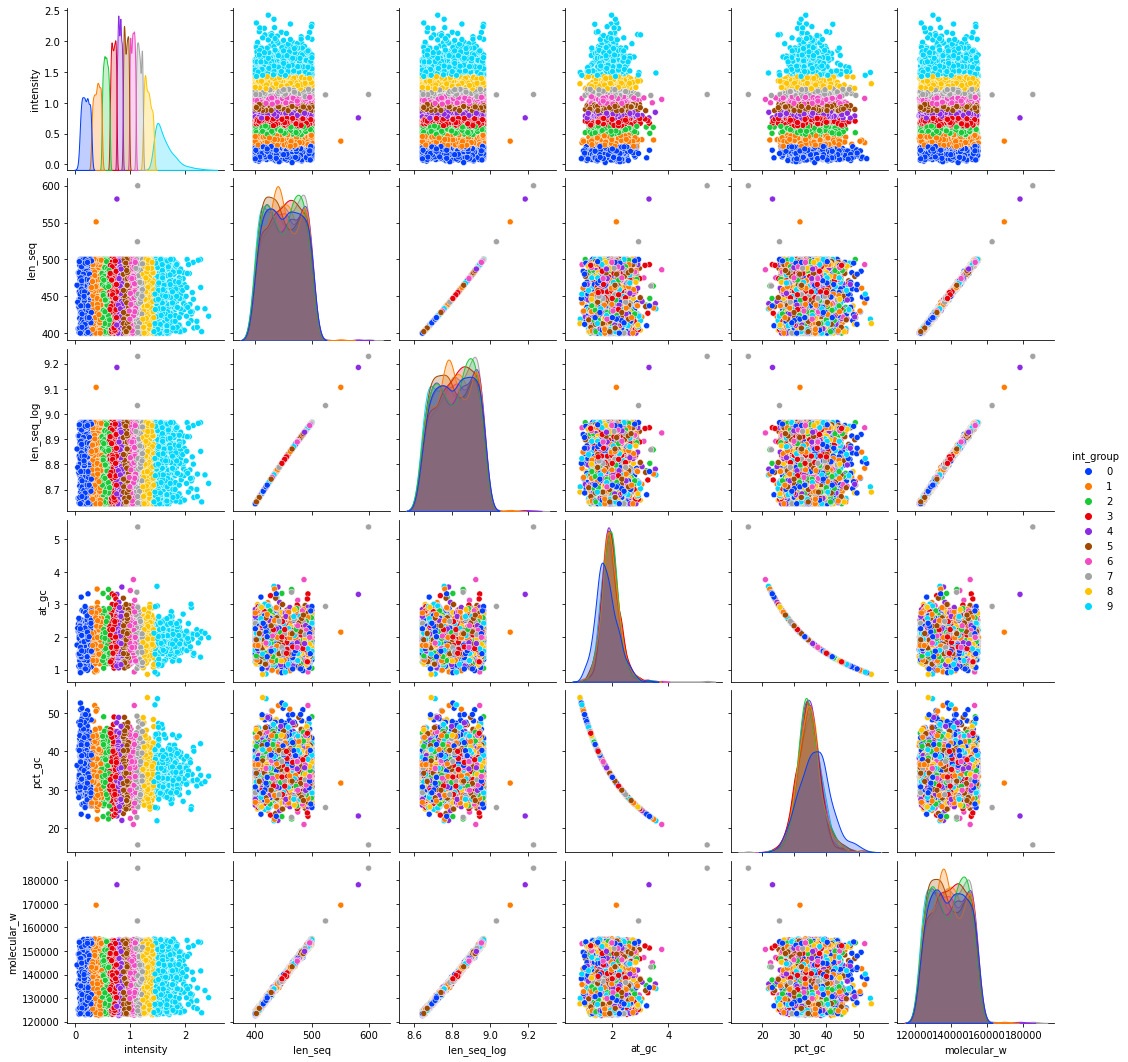

In [15]:
sns.pairplot(df, hue = 'int_group', palette = sns.color_palette('bright', 10))

In [16]:
corr = df.corr()
corr.style.background_gradient(cmap='coolwarm')

### Per group motif discovery (TBC)

[Gibbs Sampling](https://open.oregonstate.education/appliedbioinformatics/chapter/chapter-2-sequence-motifs/).

In [17]:
df.head()

gene  intensity                                            utr_seq  \
0   AI1   0.405669  TTAATGATACTCAATATGGAAAGCCGTATGATGGGAAACTATCACG...   
1   AI2   1.129300  TATTAAATATGCGTTAAATGGAGAGCCGTATGATATGAAAGTATCA...   
2   AI3   0.760753  AATTATTATTACTTTCTTCCCCTCCGAATCCGTAATATATTTACGG...   
3  TFC3   1.281130  ACATAATGAAATGAGGTGTATAAATTTTACTTTTATGTAACCAAAG...   
4  VPS8   1.203350  TTTAATACAACTTTGGTTACATAAAAGTAAAATTTATACACCTCAT...   

   int_group  len_seq  len_seq_log     at_gc     pct_gc  molecular_w  
0          1      460     8.845490  1.658960  37.608696  142350.9735  
1          7      524     9.033423  2.939850  25.381679  162779.5699  
2          4      440     8.781360  2.098592  32.272727  136104.3051  
3          8      498     8.960002  1.797753  35.742972  153882.4676  
4          7      461     8.848623  1.881250  34.707158  142086.9576

In [18]:

os.makedirs('meme_input', exist_ok=True)
def write_file(x):
    p = x['utr_seq'].apply(
        lambda y: f'>{id(y)}\n' + y)
    with open(f"meme_input/{x['int_group'].unique()[0]}.fasta", 'w') as out:
        out.write('\n'.join(p.values))
df.groupby('int_group').apply(write_file)

Empty DataFrame
Columns: []
Index: []

In [19]:
def write_inv_file(x, i):
    p = x['utr_seq'].apply(
        lambda y: f'>{id(y)}\n' + y)
    with open(f"meme_input/{i}inv.fasta", 'w') as out:
        out.write('\n'.join(p.values))
for cnt in range(10):
    write_inv_file(df[df['int_group'] != cnt], cnt)

In [20]:
os.environ['PATH'] += os.pathsep + '/home/vaslem/meme/bin:/home/vaslem/meme/libexec/meme-5.4.1'

### Trying to find motifs using MEME
- in FI decile group i using background sequences not belonging in i
- in 10th FI decile group using background sequences those in 1st

In [21]:
MINW = 5
MAXW = 10
NMOTIFS = 20
motifs = []
motifs_s = {}
try:
    with open(f'meme_output/{MINW}_{MAXW}_{NMOTIFS}_10{DID}.pkl', 'rb') as inp:
        motifs_s, motifs = pickle.load(inp)
except IOError:
    for cnt in tqdm(range(10)):
        os.system(
            f'meme meme_input/{cnt}{DID}.fasta  -p 8 -objfun de -minw {MINW}'
            f' -maxw {MAXW} -nmotifs {NMOTIFS} -evt 0.01 -oc meme_output/{cnt}{DID}  -dna -neg meme_input/{cnt}{DID}inv.fasta')
        with open(f"meme_output/{cnt}{DID}/meme.txt") as f:
            i_motifs = parse(f, 'MINIMAL')
            motifs_s[cnt] = [str(m.degenerate_consensus) for m in i_motifs]
            motifs.extend(i_motifs)
    os.system(
            f'meme meme_input/9{DID}.fasta  -p 8 -objfun de -minw {MINW}'
            f' -maxw {MAXW} -nmotifs {NMOTIFS} -evt 0.01 -oc meme_output/ex{DID} -dna -neg meme_input/0{DID}.fasta')
    with open(f"meme_output/ex{DID}/meme.txt") as f:
        i_motifs = parse(f, 'MINIMAL')
        motifs_s[10] = [str(m.degenerate_consensus) for m in i_motifs]
        motifs.extend(i_motifs)
    with open(f'meme_output/{MINW}_{MAXW}_{NMOTIFS}_10{DID}.pkl', 'wb') as out:
        pickle.dump((motifs_s, motifs), out)

In [22]:
motifsDecileDf = pd.Series(motifs_s).reset_index().rename(columns={'index':'group',0:'motif'})
motifsDecileDf['group_type'] = 'fi_decile_vs_rest'
motifsDecileDf.loc[10, 'group_type'] = 'fi_decile_9_vs_0'
motifsDecileDf = motifsDecileDf.explode('motif').dropna()

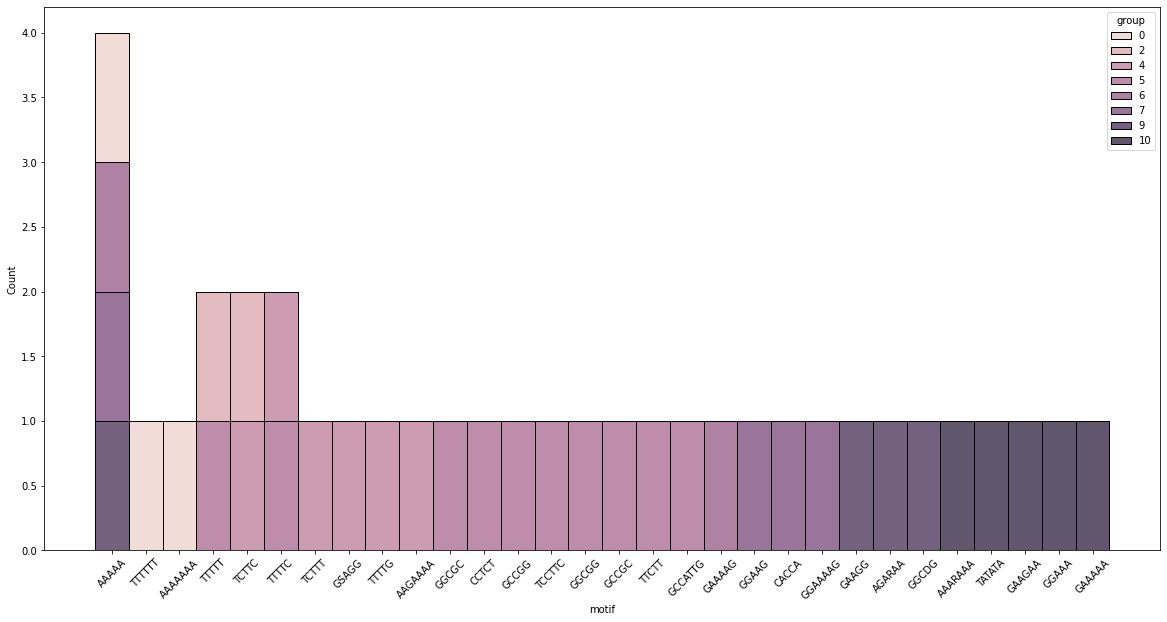

In [61]:
# There may be motifs that are seen more than once inside the motifs list, 
# because of the grouping performed during searching for them based on intensity
plt.figure(figsize=(20,10))
sns.histplot(motifsDecileDf,x='motif', hue='group', multiple='stack')
_ = plt.xticks(rotation=45)
plt.savefig(f'../figures/motifsCounts{DID}.png', dpi=100)

In [24]:
seqs = [Seq(x) for x in df['utr_seq']]

### Creating Features

In [25]:
def create_features(seqs, motifs):
    scores = np.zeros([len(seqs), len(motifs)])
    counts = np.zeros([len(seqs), len(motifs)])
    for s_c, seq in tqdm(enumerate(seqs)):
        for m_c, motif in enumerate(motifs):
            counts[s_c, m_c] = 0
            if len(seq) < len(motif):
                continue
            weights = motif.pssm
            sc = weights.calculate(seq)
            
            counts[s_c, m_c] = np.sum(sc > 0)
            if not counts[s_c, m_c]:
                continue
            scores[s_c, m_c] = np.median(sc[sc>0])
                
    return counts, scores
    
            
counts, scores = create_features(seqs, motifs)

In [26]:
other_feats = ['len_seq', 'len_seq_log', 'at_gc', 'pct_gc', 'molecular_w']
motifs_ids = [str(m.degenerate_consensus) for m in motifs]
motifs_scores_ids = [c + '_score' for c in motifs_ids]
motifs_tfidf_ids = [c + '_tfidf' for c in motifs_ids]
seq_columns = motifs_scores_ids + motifs_tfidf_ids
uni_ind = list(set([seq_columns.index(x) for x in seq_columns]))
features = np.array(seq_columns)[uni_ind].tolist()
columns_scores = [feat for feat in features if feat.endswith('_score')]
columns_tfidf = [feat for feat in features if feat.endswith('_tfidf')]

In [27]:
tfidf = TfidfTransformer().fit_transform(counts)
tfidf = tfidf.todense()
featDf = pd.DataFrame(np.hstack([scores, tfidf]), columns=seq_columns)
featDf = featDf.iloc[:,uni_ind]
featDf[:] = SimpleImputer().fit_transform(featDf)
features += other_feats
featDf = pd.concat([featDf,df[other_feats + ['intensity', 'int_group']]], axis=1)
featDf.head()

AAAAA_score  TTTTTT_score  AAAAAAA_score  TTTTT_score  TCTTC_score  \
0     0.000000      0.000000        0.00000     7.975484     0.000000   
1     8.264506      0.000000       11.57031     0.000000     9.717168   
2     8.264506      0.000000        0.00000     0.000000     9.717168   
3     8.264506      9.917408        0.00000     7.975484     0.000000   
4     0.000000      0.000000        0.00000     0.000000     0.000000   

   TTTTC_score  TCTTT_score  GSAGG_score  TTTTG_score  AAGAAAA_score  ...  \
0     8.878566     8.878566     0.000000     8.962467            0.0  ...   
1     0.000000     8.878566    11.197246     8.962467            0.0  ...   
2     0.000000     0.000000    10.567062     0.000000            0.0  ...   
3     8.878566     8.878566     0.000000     8.962467            0.0  ...   
4     0.000000     8.878566     0.000000     8.962467            0.0  ...   

   GAAGAA_tfidf  GGAAA_tfidf  GAAAAA_tfidf  len_seq  len_seq_log     at_gc  \
0      0.000000     0.727634      0.000000      460     8.845490  1.658960   
1      0.000000     0.074390      0.000000      524     9.033423  2.939850   
2      0.000000     0.408870      0.000000      440     8.781360  2.098592   
3      0.153248     0.000000      0.127129      498     8.960002  1.797753   
4      0.000000     0.000000      0.000000      461     8.848623  1.881250   

      pct_gc  molecular_w  intensity  int_group  
0  37.608696  142350.9735   0.405669          1  
1  25.381679  162779.5699   1.129300          7  
2  32.272727  136104.3051   0.760753          4  
3  35.742972  153882.4676   1.281130          8  
4  34.707158  142086.9576   1.203350          7  

[5 rows x 67 columns]

### Features Exploration / Analysis

Checking for significant difference in FI between genes with and without a found motif.

In [28]:
p_vals = {}
for e in columns_scores:
    grp0 = featDf.loc[featDf[e] == 0].intensity
    grp1 = featDf.loc[featDf[e] != 0].intensity
    f_val, p_val = stats.ttest_ind(grp0, grp1)   
    p_vals[e.replace('_score', '')] = p_val
anovaPresence = pd.Series(p_vals).reset_index().rename(columns={'index':'motif', 0:'pval'})
anovaPresence = anovaPresence.merge(motifsDecileDf, on='motif')

In [29]:
anovaPresence['qval'] = fdrcorrection(anovaPresence['pval'])[1]
anovaPresence = anovaPresence.sort_values('qval').reset_index(drop=True)
anovaPresence.head()

motif          pval  group         group_type          qval
0  TATATA  1.107475e-32     10   fi_decile_9_vs_0  3.986910e-31
1   AAAAA  2.718561e-04      0  fi_decile_vs_rest  1.631137e-03
2   AAAAA  2.718561e-04      6  fi_decile_vs_rest  1.631137e-03
3   AAAAA  2.718561e-04      7  fi_decile_vs_rest  1.631137e-03
4   AAAAA  2.718561e-04      9  fi_decile_vs_rest  1.631137e-03

In [30]:
anovaPresence['log_qval'] = -np.log10(anovaPresence['qval'])

In [31]:
sig_mots = anovaPresence.drop_duplicates('motif').query('qval < 0.01')

In [32]:
len(sig_mots)

9

In [33]:
sig_mots['motif'].values.tolist()

['TATATA',
 'AAAAA',
 'AGARAA',
 'AAARAAA',
 'GSAGG',
 'GAAAAA',
 'TTTTT',
 'AAGAAAA',
 'GGCGC']

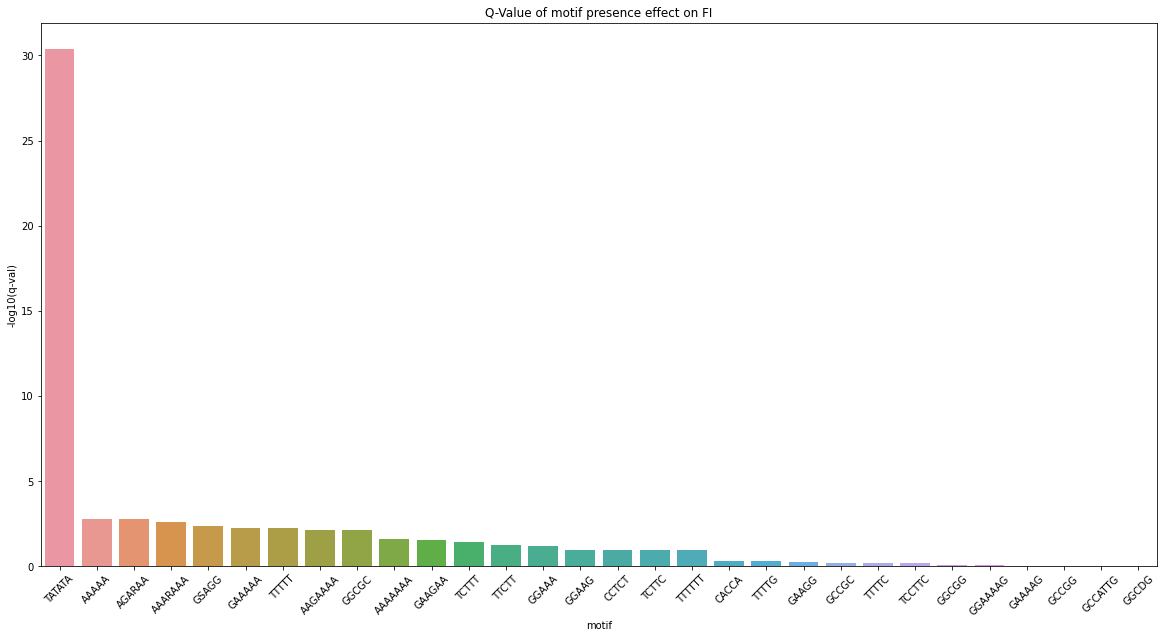

In [34]:
plt.figure(figsize=(20,10))
sns.barplot(data=anovaPresence.drop_duplicates('motif'), x='motif', y='log_qval')
plt.xticks(rotation=45)
plt.ylabel('-log10(q-val)')
_ = plt.title("Q-Value of motif presence effect on FI")
plt.savefig(f'../figures/motifsPresenceQvalues{DID}.png', dpi=100)

### PCA

In [35]:
normFeatDf = featDf[features].copy()
# normFeatDf = df_6mers_test.loc[:, (df_6mers.columns != 'gene') & (df_6mers.columns != 'intensity')]
normFeatDf = (normFeatDf-normFeatDf.mean())/normFeatDf.std()
# normFeatDf = (normFeatDf-normFeatDf.min())/(normFeatDf.max()-normFeatDf.min())

In [36]:
pca = PCA(n_components = 7)
components = pca.fit_transform(normFeatDf[features])
labels = {
    str(i): f"PC {i+1} ({var:.1f}%)"
    for i, var in enumerate(pca.explained_variance_ratio_ * 100)
}

total_var = pca.explained_variance_ratio_.sum() * 100

fig = px.scatter_matrix(
    components,
    labels=labels,
    dimensions=range(7),
    color=df.int_group,
    title=f'Total Explained Variance: {total_var:.2f}%',
)
fig.update_traces(diagonal_visible=False)
fig.show()

In [37]:
loadings = pca.components_.T * np.sqrt(pca.explained_variance_)

x = 0
y = 1

fig = px.scatter(components, x=x, y=y, color=df.int_group)

for i, feature in enumerate(features):
    fig.add_shape(
        type='line',
        x0=0, y0=0,
        x1=loadings[i, x],
        y1=loadings[i, y]
    )
    fig.add_annotation(
        x=loadings[i, x],
        y=loadings[i, y],
        ax=0, ay=0,
        xanchor="center",
        yanchor="bottom",
        text=feature,
    )
fig.show()

In [38]:
exp_var_cumul = np.cumsum(pca.explained_variance_ratio_)

px.area(
    x=range(1, exp_var_cumul.shape[0] + 1),
    y=exp_var_cumul,
    labels={"x": "# Components", "y": "Explained Variance"}
)

In [39]:
mapper = UMAP().fit(normFeatDf[features])

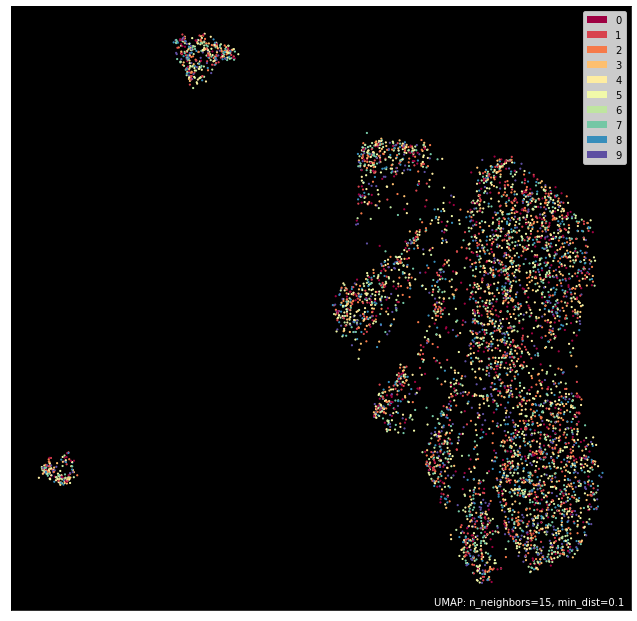

In [40]:
umap.plot.points(mapper, labels=featDf['int_group'], theme="viridis")
plt.savefig(f'../figures/seqbasedfeatsumap{DID}.png', dpi=100)

In [41]:
all_motifs_str = [str(m.degenerate_consensus) for m in motifs]

/home/vaslem/code/kaggle/.venv/lib/python3.8/site-packages/seaborn/matrix.py:659: UserWarning:

Clustering large matrix with scipy. Installing `fastcluster` may give better performance.



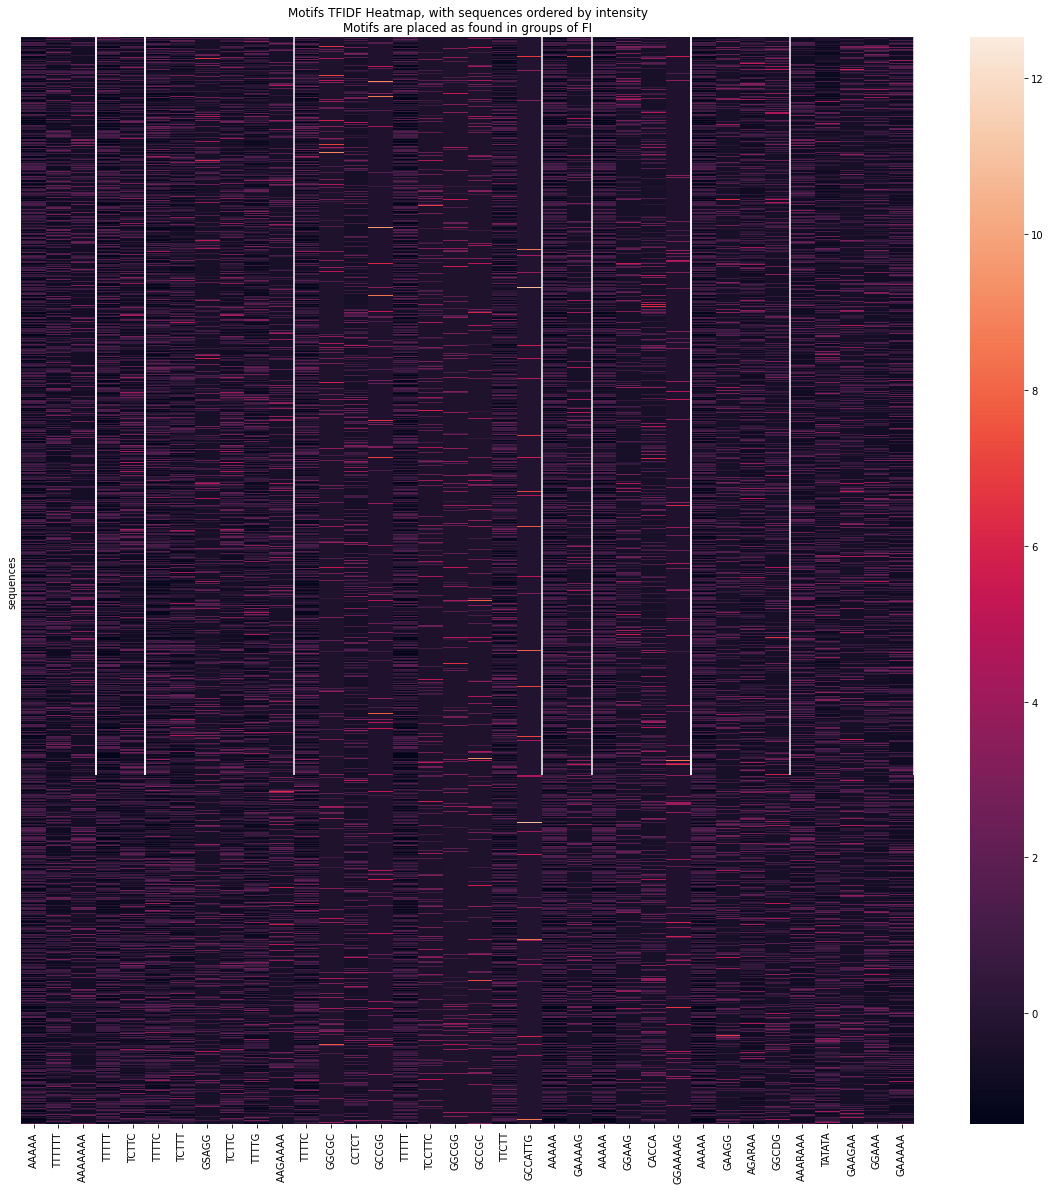

<Figure size 1440x1440 with 0 Axes>

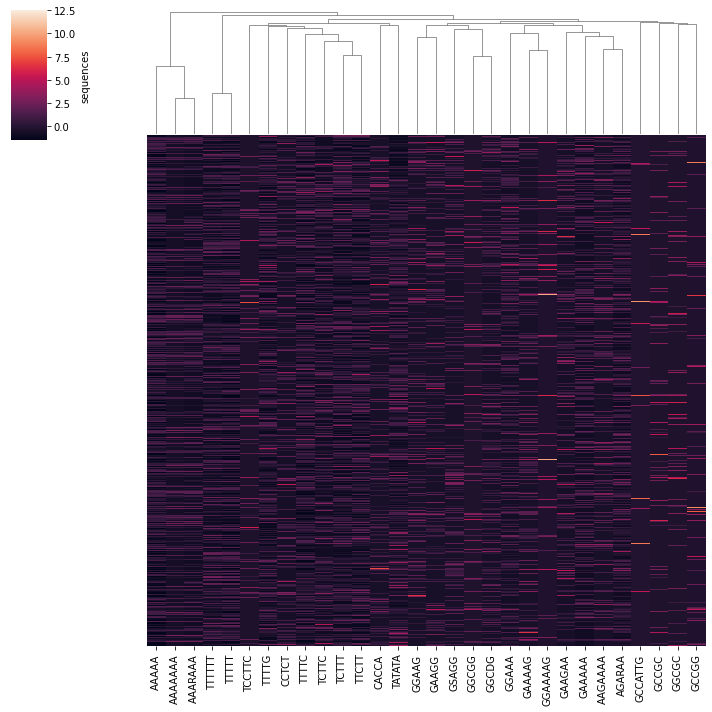

In [42]:
tfidfDf = normFeatDf[columns_tfidf].rename(columns=lambda x: x.replace('_tfidf', ''))
tfidfDfFeats = tfidfDf.columns.tolist()
tfidfDf['intensity'] = featDf.intensity
plt.figure(figsize=(20,20))
ax = sns.heatmap(tfidfDf.sort_values('intensity')[all_motifs_str],yticklabels=False)
_ = ax.vlines(np.cumsum([len(motifs_s[x]) for x in range(11)]), 0, ax.get_xlim()[1] * 100, colors='w')
plt.title('Motifs TFIDF Heatmap, with sequences ordered by intensity\nMotifs are placed as found in groups of FI')
plt.ylabel('sequences')
plt.savefig('../figures/motifTfidfHeatmap{DID}.png', dpi=100)
plt.figure(figsize=(20,20))
_ = sns.clustermap(tfidfDf.sort_values('intensity')[tfidfDfFeats],yticklabels=False,row_cluster=False)
plt.ylabel('sequences')
plt.savefig(f'../figures/motifTfidfClustermap{DID}.png', dpi=100)

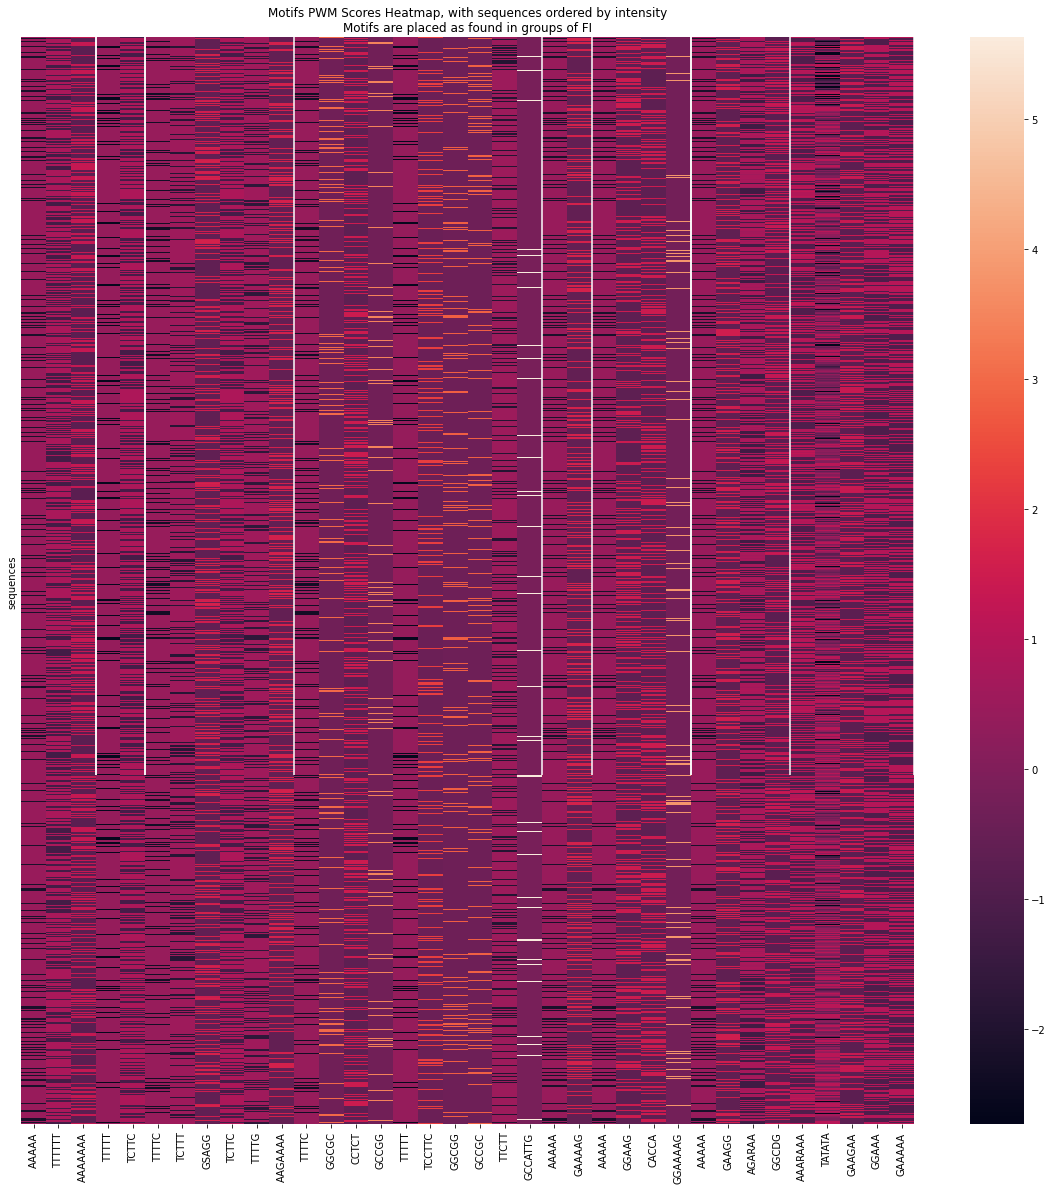

<Figure size 1440x1440 with 0 Axes>

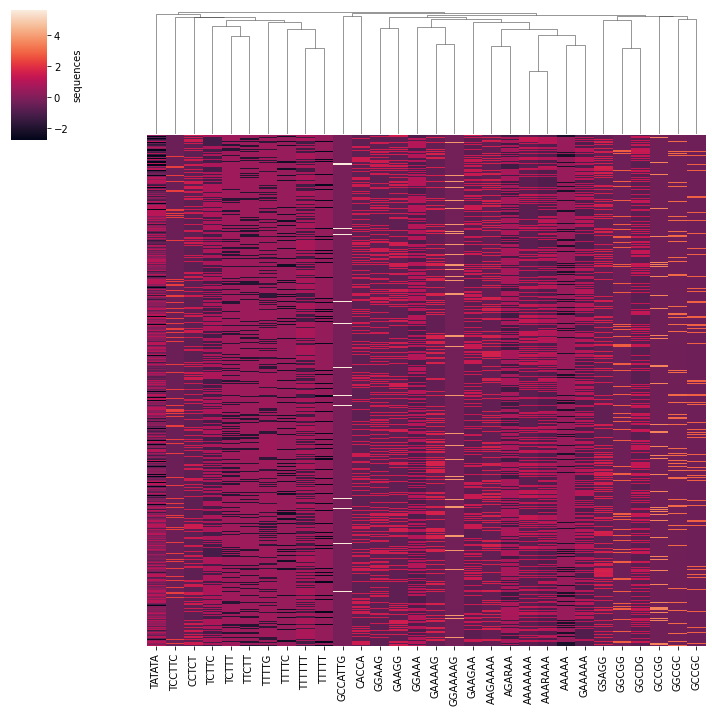

In [43]:
scoreDf = normFeatDf[columns_scores].rename(columns=lambda x: x.replace('_score', ''))
scoreDfFeats = scoreDf.columns.tolist()
scoreDf['intensity'] = featDf.intensity
plt.figure(figsize=(20,20))
ax = sns.heatmap(scoreDf.sort_values('intensity')[all_motifs_str],yticklabels=False)
_ = ax.vlines(np.cumsum([len(motifs_s[x]) for x in range(11)]), 0, ax.get_xlim()[1] * 100, colors='w')
plt.title('Motifs PWM Scores Heatmap, with sequences ordered by intensity\nMotifs are placed as found in groups of FI')
plt.ylabel('sequences')
plt.savefig(f'../figures/motifScoresHeatmap{DID}.png', dpi=100)
plt.figure(figsize=(20,20))
_ = sns.clustermap(scoreDf.sort_values('intensity')[scoreDfFeats],yticklabels=False,row_cluster=False)
plt.ylabel('sequences')
plt.savefig(f'../figures/motifScoresClustermap{DID}.png', dpi=100)

### Classification (RF)
Does a sequence belong to the upper (decile>=5) or lower FI range?

In [44]:
df_subset = featDf.copy()
df_subset['int_bool'] = df_subset.int_group.astype(float) >= 5
X = df_subset.loc[:,features]
y = df_subset.int_bool
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5,
                                                    stratify=df_subset.int_bool, random_state=123456)

Checking how well a Decision Tree can distinguish the label

Mean accuracy score: 0.567


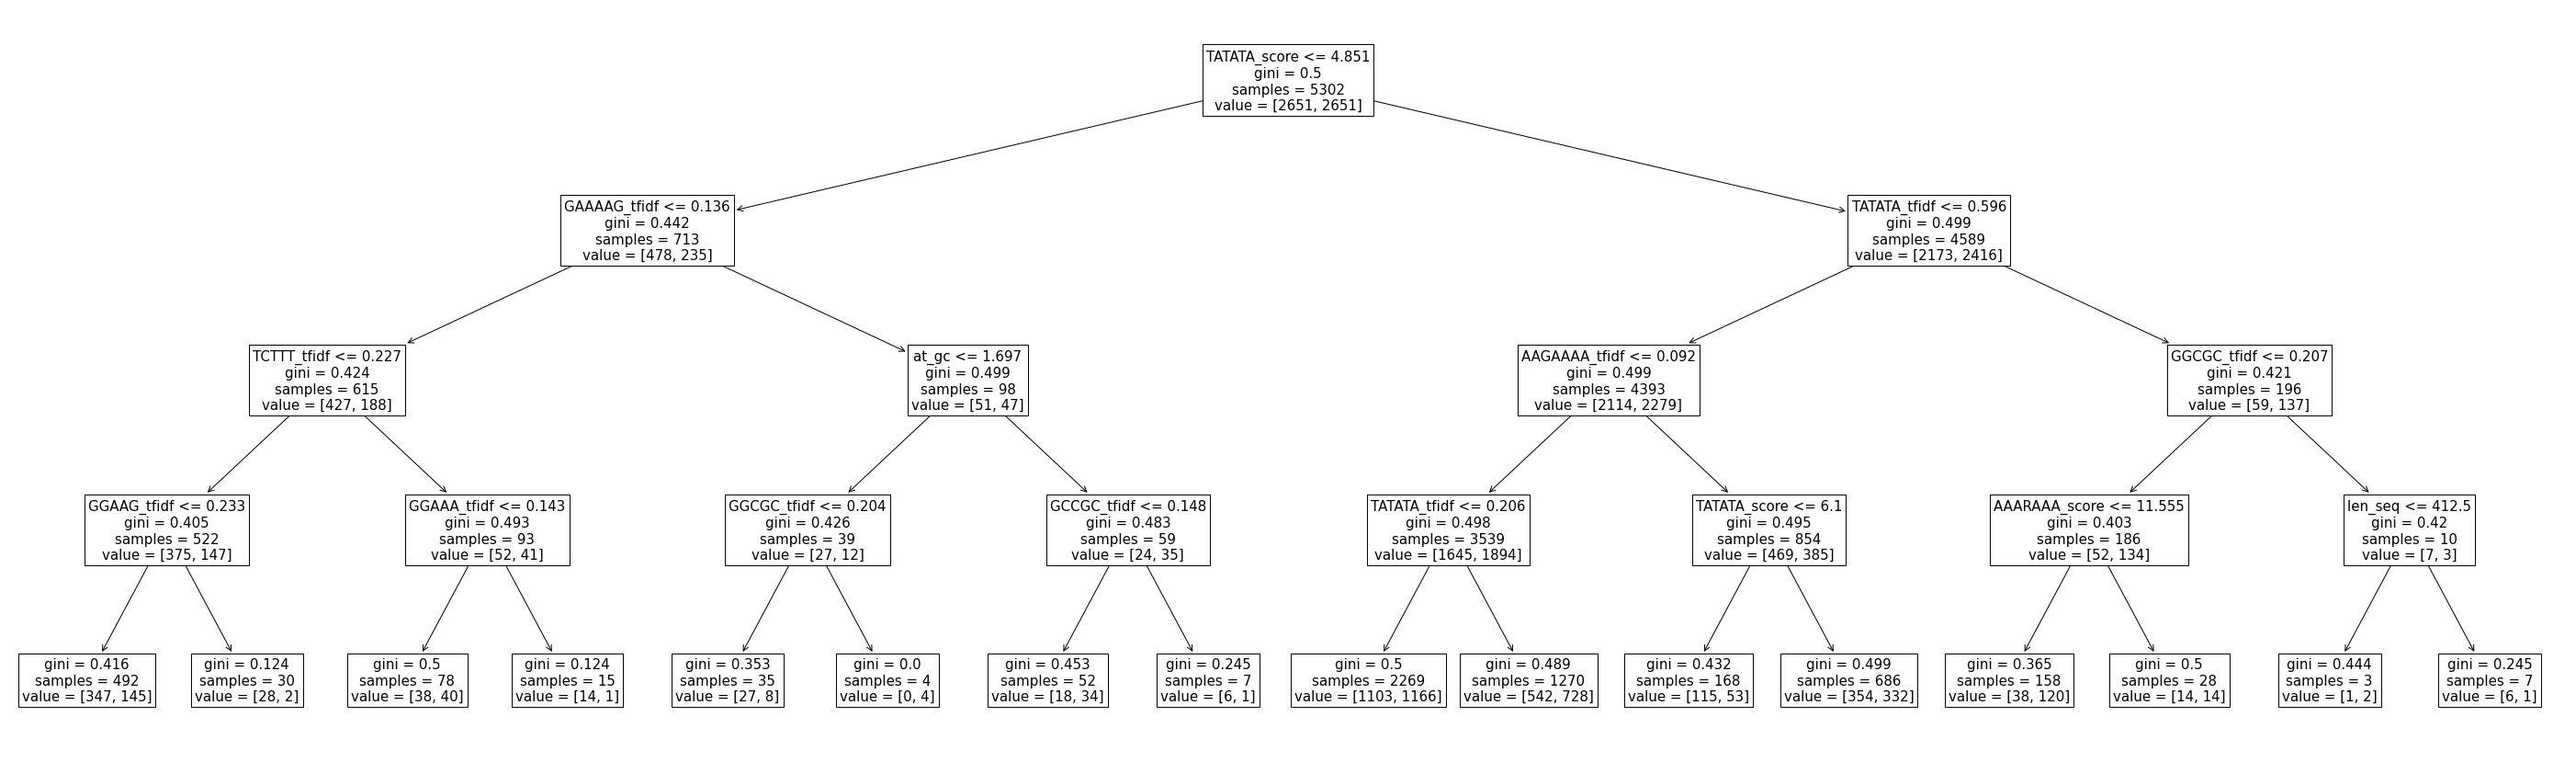

In [45]:
t = DecisionTreeClassifier(random_state=123456, max_depth=4)
t.fit(X, y)
predicted = t.predict(X)
accuracy = accuracy_score(y, predicted)
print(f'Mean accuracy score: {accuracy:.3}')
fig,ax=plt.subplots(1,1, figsize=(50,15))
_ = plot_tree(t,feature_names=features,ax=ax,fontsize=15)

In [46]:
rf = RandomForestClassifier(n_estimators=500, oob_score=True, random_state=123456)
rf.fit(X_train, y_train)

/home/vaslem/code/kaggle/.venv/lib/python3.8/site-packages/sklearn/base.py:445: UserWarning:

X does not have valid feature names, but RandomForestClassifier was fitted with feature names



RandomForestClassifier(n_estimators=500, oob_score=True, random_state=123456)

In [47]:
predicted = rf.predict(X_train)
accuracy = accuracy_score(y_train, predicted)
print(f'Out-of-bag score estimate: {rf.oob_score_:.3}')
print(f'Mean accuracy score: {accuracy:.3}')

Out-of-bag score estimate: 0.542
Mean accuracy score: 1.0


In [48]:

predicted = rf.predict(X_test)
accuracy = accuracy_score(y_test, predicted)
print(f'Out-of-bag score estimate: {rf.oob_score_:.3}')
print(f'Mean accuracy score: {accuracy:.3}')

Out-of-bag score estimate: 0.542
Mean accuracy score: 0.551


<AxesSubplot:>

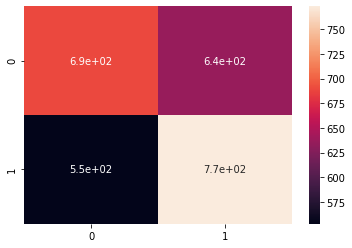

In [49]:

cm = pd.DataFrame(confusion_matrix(y_test, predicted), columns=range(2), index=range(2))
sns.heatmap(cm, annot=True)

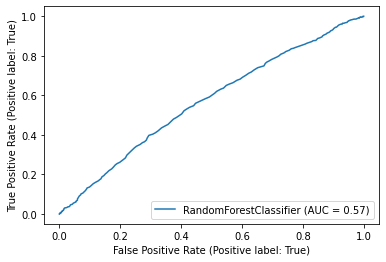

In [50]:
rf_disp = RocCurveDisplay.from_estimator(rf, X_test, y_test)
plt.show()

### Regression (RF)

In [51]:
df_subset.shape

(5302, 68)

In [52]:
df_subset = featDf.copy()
X = df_subset.loc[:,features]
y = df_subset.intensity

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=42)
scaler = StandardScaler().fit(X_train)
X_train_scaled = pd.DataFrame(scaler.transform(X_train), index=X_train.index.values, columns=X_train.columns.values)
X_test_scaled = pd.DataFrame(scaler.transform(X_test), index=X_test.index.values, columns=X_test.columns.values)

Checking how well a Decision Tree can distinguish intensities

MSE: 0.16


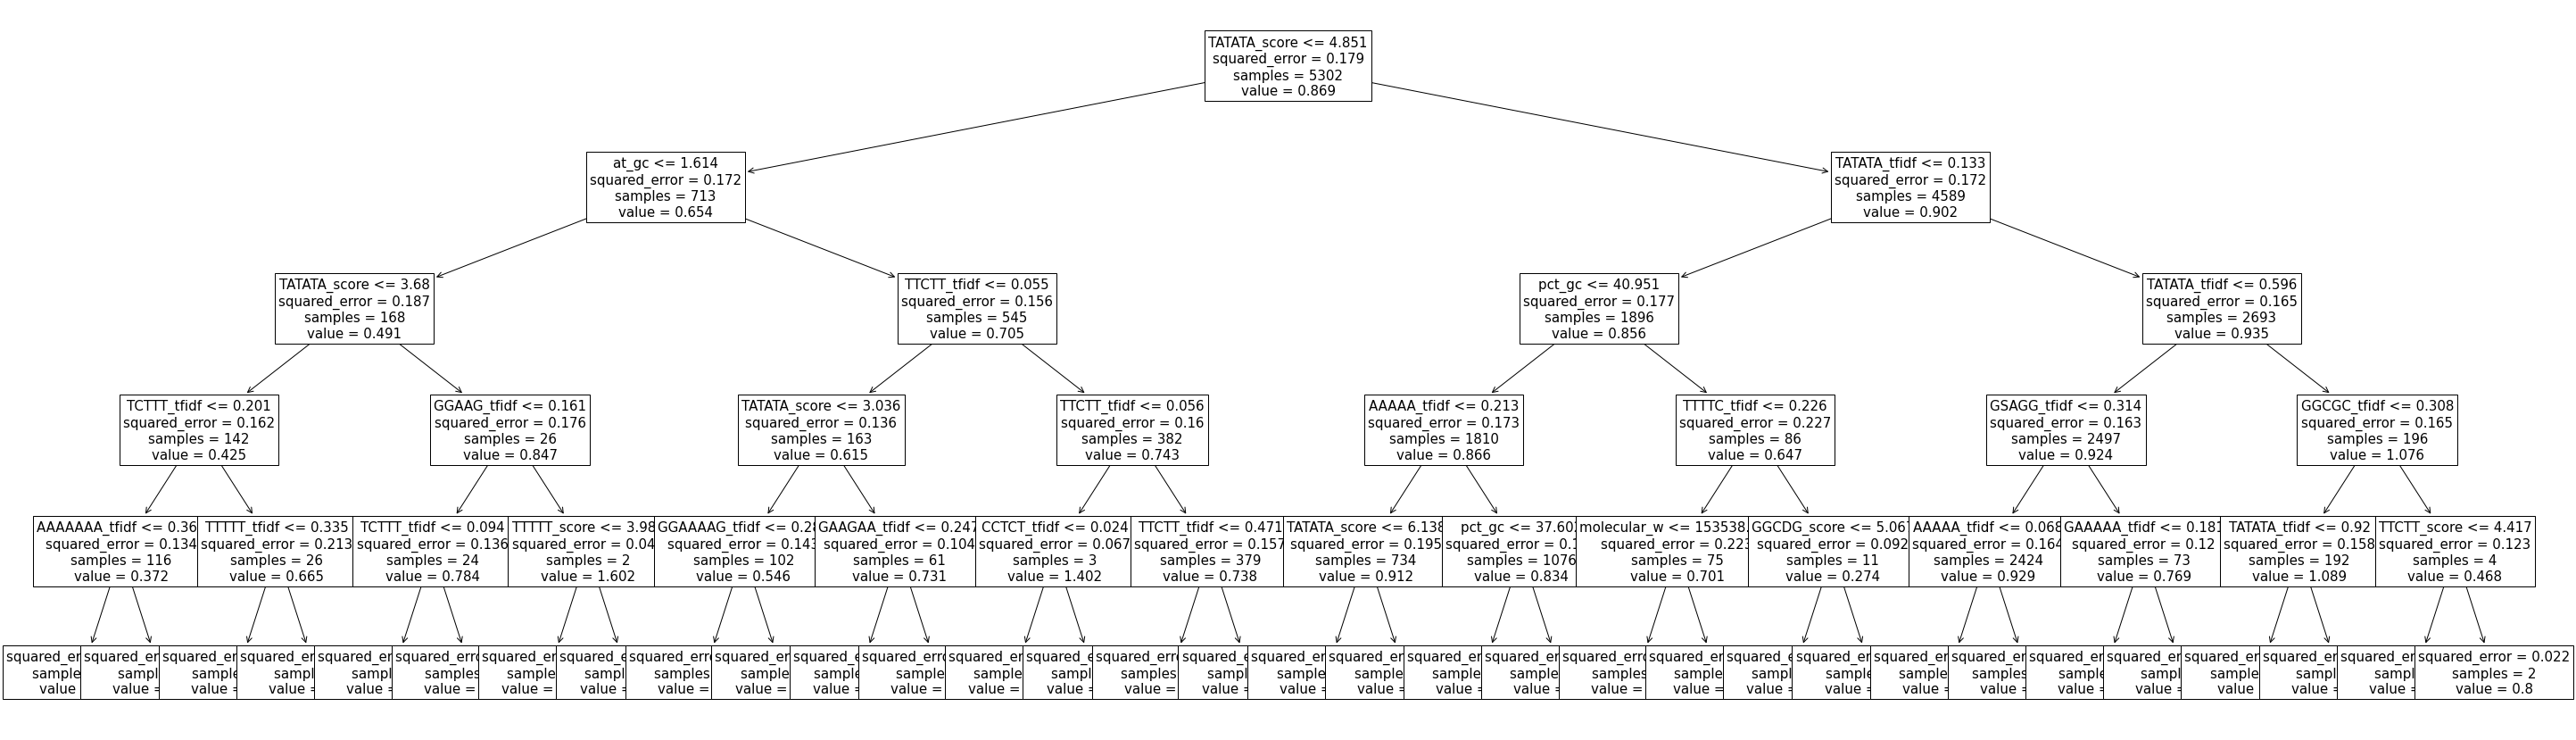

In [53]:
t = DecisionTreeRegressor(random_state=123456, max_depth=5)
t.fit(X, y)
predicted = t.predict(X)
m = mse(y, predicted)
print(f'MSE: {m:.3}')
fig,ax=plt.subplots(1,1, figsize=(50,15))
_ = plot_tree(t,feature_names=features,ax=ax,fontsize=15)

In [54]:
rf = RandomForestRegressor(n_estimators=500, oob_score=True, random_state=0, n_jobs=-1)
rf.fit(X_train, y_train)

/home/vaslem/code/kaggle/.venv/lib/python3.8/site-packages/sklearn/base.py:445: UserWarning:

X does not have valid feature names, but RandomForestRegressor was fitted with feature names



RandomForestRegressor(n_estimators=500, n_jobs=-1, oob_score=True,
                      random_state=0)

In [55]:
predicted_train = rf.predict(X_train)
predicted_test = rf.predict(X_test)
test_score = r2_score(y_test, predicted_test)
spearman = spearmanr(y_test, predicted_test)
pearson = pearsonr(y_test, predicted_test)
m = mse(y_test, predicted_test)
print(f'Test data MSE: {m:.3}')
print(f'Out-of-bag R-2 score estimate: {rf.oob_score_:>5.3}')
print(f'Test data R-2 score: {test_score:>5.3}')
print(f'Test data Spearman correlation: {spearman[0]:.3}')
print(f'Test data Pearson correlation: {pearson[0]:.3}')

Test data MSE: 0.167
Out-of-bag R-2 score estimate: 0.0475
Test data R-2 score: 0.0316
Test data Spearman correlation: 0.191
Test data Pearson correlation: 0.207


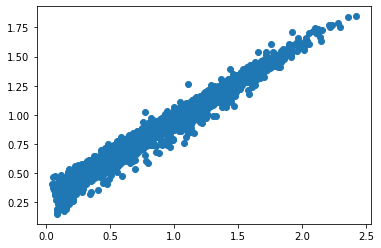

In [56]:
plt.scatter(y_train, predicted_train)

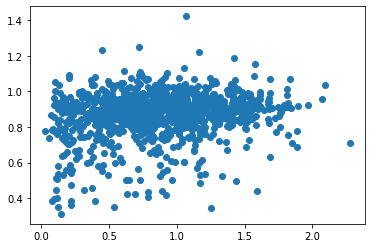

In [57]:
plt.scatter(y_test, predicted_test)

### Try only with last group motifs (9 vs 0) features and using groups 0 and 9

In [58]:

subset_feats = ([x + '_score' for x in motifs_s[10]] +
                       [x + '_tfidf' for x in motifs_s[10]])

df_subset = featDf.loc[featDf['int_group'].isin([0,9]), subset_feats + ['int_group']
                       ].copy()
df_subset['int_bool'] = df_subset.int_group.astype(float) >= 5
X = df_subset[subset_feats]
y = df_subset.int_bool

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5,
                                                    stratify=df_subset.int_bool, random_state=123456)
rf = RandomForestClassifier(n_estimators=500, oob_score=True, random_state=123456)
rf.fit(X_train, y_train)

predicted = rf.predict(X_train)
accuracy = accuracy_score(y_train, predicted)
print(f'Out-of-bag score estimate: {rf.oob_score_:.3}')
print(f'Mean accuracy train score: {accuracy:.3}')
predicted = rf.predict(X_test)
accuracy = accuracy_score(y_test, predicted)
print(f'Mean accuracy test score: {accuracy:.3}')

/home/vaslem/code/kaggle/.venv/lib/python3.8/site-packages/sklearn/base.py:445: UserWarning:

X does not have valid feature names, but RandomForestClassifier was fitted with feature names



Out-of-bag score estimate: 0.646
Mean accuracy train score: 0.996
Mean accuracy test score: 0.608


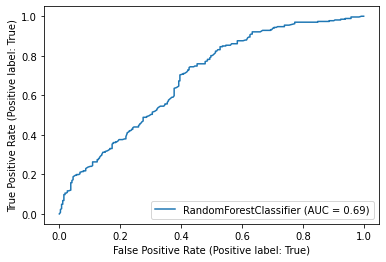

In [59]:
rf_disp = RocCurveDisplay.from_estimator(rf, X_test, y_test)
plt.show()

Mean accuracy score: 0.688


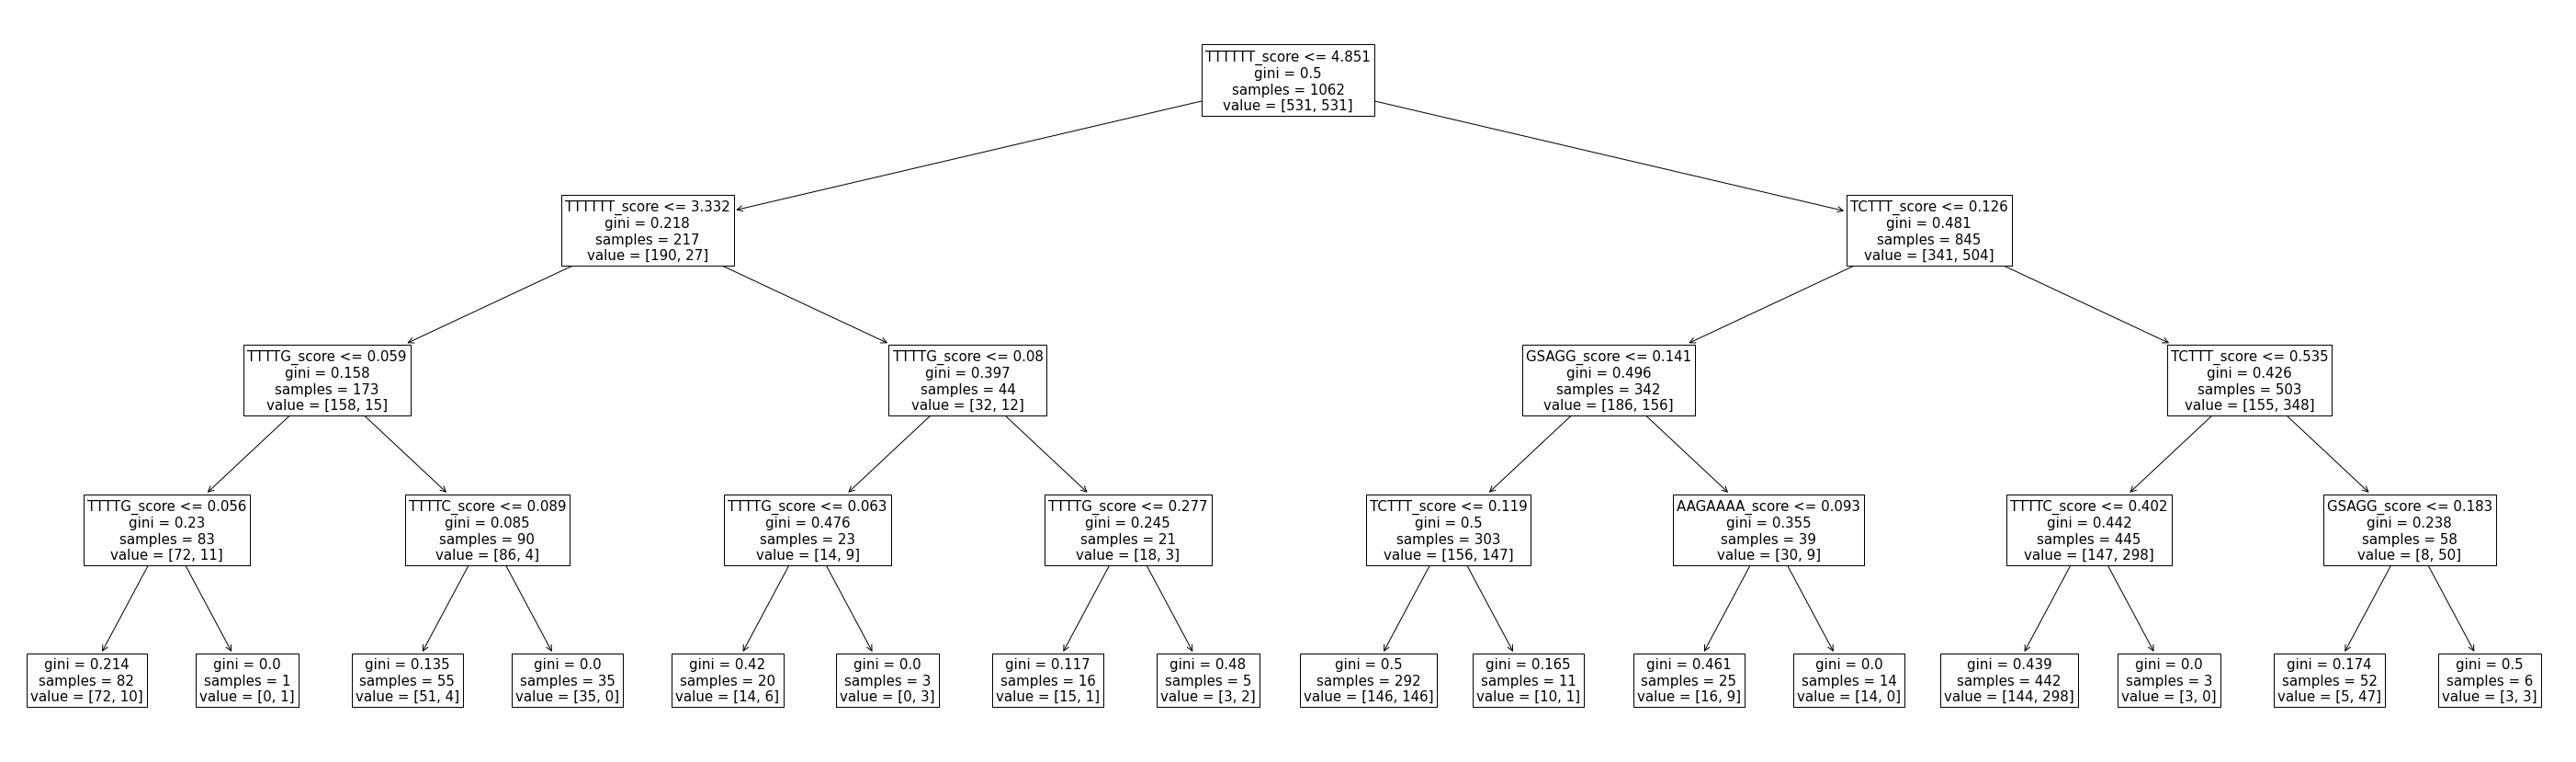

In [60]:
t = DecisionTreeClassifier(random_state=123456, max_depth=4)
t.fit(X, y)
predicted = t.predict(X)
accuracy = accuracy_score(y, predicted)
print(f'Mean accuracy score: {accuracy:.3}')
fig,ax=plt.subplots(1,1, figsize=(50,15))
_ = plot_tree(t,feature_names=features,ax=ax,fontsize=15)
plt.savefig(f'../figures/motifs9vs0{DID}.png', dpi=100)